Kaggleのデータセットを用いて、クラウドファンディングが成功するか否かを予測する

### 1.データセットの確認

### 1.1 目的変数について

　・クラウドファンディングが成功するかどうかを示す「state」が目的変数

### 1.2 データの内容を確認

In [1]:
#必要なライブラリを読み込む

%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#データの読み込み
df_data= pd.read_csv("../ks-projects-201801/ks-projects-201801.csv")

display(df_data.head())
df_data.describe()
df_data.info()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


### 2. データの整理

### 2.1 データの可視化

In [3]:
#変数それぞれの相関係数を求める
df_data.corr()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
ID,1.000000,0.001679,0.000466,0.000654,-0.000633,-0.000025,0.001854
goal,0.001679,1.000000,0.007358,0.004012,0.005534,0.005104,0.942692
pledged,0.000466,0.007358,1.000000,0.717079,0.857370,0.952843,0.005024
backers,0.000654,0.004012,0.717079,1.000000,0.697426,0.752539,0.004517
usd pledged,-0.000633,0.005534,0.857370,0.697426,1.000000,0.907743,0.006172
usd_pledged_real,-0.000025,0.005104,0.952843,0.752539,0.907743,1.000000,0.005596
usd_goal_real,0.001854,0.942692,0.005024,0.004517,0.006172,0.005596,1.000000


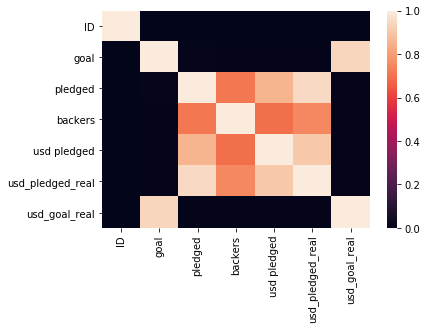

In [4]:
sns.heatmap(df_data.corr())
plt.show()

### 2.2 不要なカラムの削除

今回のカラムのうち、以下のカラムは不要であると判断し、削除する。

・ID （プロジェクトの成否には関係ないと推測）

・name　（プロジェクトの成否には関係ないと推測）

・category （別カラムのmain_categoryを使用する）

・goal　（別カラムのusd_goal_realを使用する）

・pledged　(結果として得られる数値なので、使用しない）

・usd pledged　(結果として得られる数値なので、使用しない）

・usd_pledged_real (結果として得られる数値なので、使用しない）

In [5]:
df_data = df_data.drop(['ID','name','category','goal','pledged','usd pledged', 'usd_pledged_real'], axis=1)
df_data.head()

,main_category,currency,deadline,launched,state,backers,country,usd_goal_real
0,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,0,GB,1533.95
1,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,15,US,30000.00
2,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,3,US,45000.00
3,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,1,US,5000.00
4,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,14,US,19500.00


### 2.3 欠損値の確認

In [6]:
df_data.isnull().sum()

main_category    0
currency         0
deadline         0
launched         0
state            0
backers          0
country          0
usd_goal_real    0
dtype: int64

欠損値がないため、欠損値処理は行わない。

### 2.4 データの変換

deadlineとlaunchedについて、プロジェクトの開始日と終了日よりも日数の方が重要と判断し、days（日数）にデータを変換する

In [7]:
df_data["deadline"] = pd.to_datetime(df_data["deadline"], errors = "coerce")
df_data["launched"] = pd.to_datetime(df_data["launched"], errors = "coerce")

In [8]:
df_data["days"] = (df_data["deadline"] - df_data["launched"]).dt.days

In [9]:
df_data = df_data.drop(["deadline","launched"], axis=1)

In [10]:
df_data.head()

,main_category,currency,state,backers,country,usd_goal_real,days
0,Publishing,GBP,failed,0,GB,1533.95,58
1,Film & Video,USD,failed,15,US,30000.00,59
2,Film & Video,USD,failed,3,US,45000.00,44
3,Music,USD,failed,1,US,5000.00,29
4,Film & Video,USD,canceled,14,US,19500.00,55


### 2.5 目的変数の処理

In [11]:
# 目的変数stateを一番左の列に移動
col = df_data.columns.tolist()
col.remove('state')
col.insert(0,'state')
df_data = df_data.loc[:,col]

In [12]:
df_data.head()

,state,main_category,currency,backers,country,usd_goal_real,days
0,failed,Publishing,GBP,0,GB,1533.95,58
1,failed,Film & Video,USD,15,US,30000.00,59
2,failed,Film & Video,USD,3,US,45000.00,44
3,failed,Music,USD,1,US,5000.00,29
4,canceled,Film & Video,USD,14,US,19500.00,55


In [13]:
df_data["state"].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [14]:
# successfulとfailed以外を削除
df_data = df_data[(df_data['state'] == 'successful') | (df_data['state'] == 'failed')]

In [15]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 7 columns):
state            331675 non-null object
main_category    331675 non-null object
currency         331675 non-null object
backers          331675 non-null int64
country          331675 non-null object
usd_goal_real    331675 non-null float64
days             331675 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 20.2+ MB


### 3. 目的変数と説明変数の関係

目的変数と説明変数の関係性を表すグラフを記載する

### 3.1 state と main_category

主なカテゴリー別に見たクラウドファンディングの成否


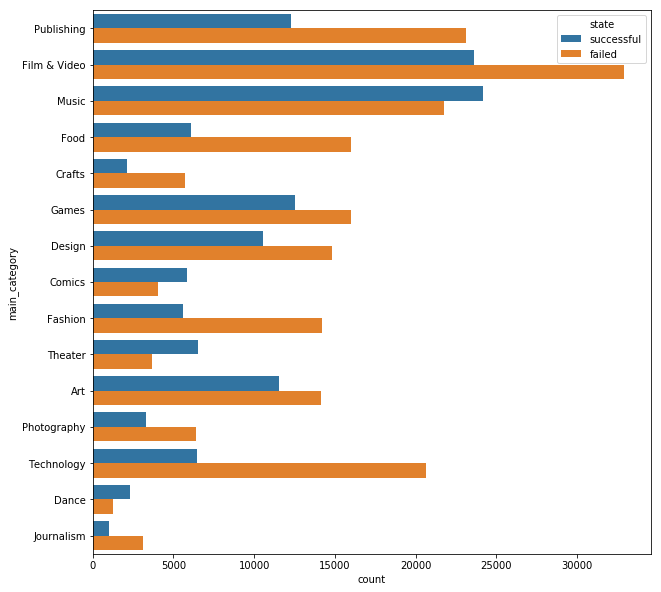

In [16]:
def showmaincategoryHist(data):
    print("主なカテゴリー別に見たクラウドファンディングの成否")
    sns.countplot(y="main_category", hue="state", hue_order=["successful", "failed"], data=data)
    plt.show()

plt.figure(figsize=(10,10))
showmaincategoryHist(df_data)

カテゴリーごとにクラウドファンディングの成否にばらつきがあるため、カテゴリーは目的変数に影響を及ぼしていると推測する。

### 3.2 state と currency

通貨別に見たクラウドファンディングの成否


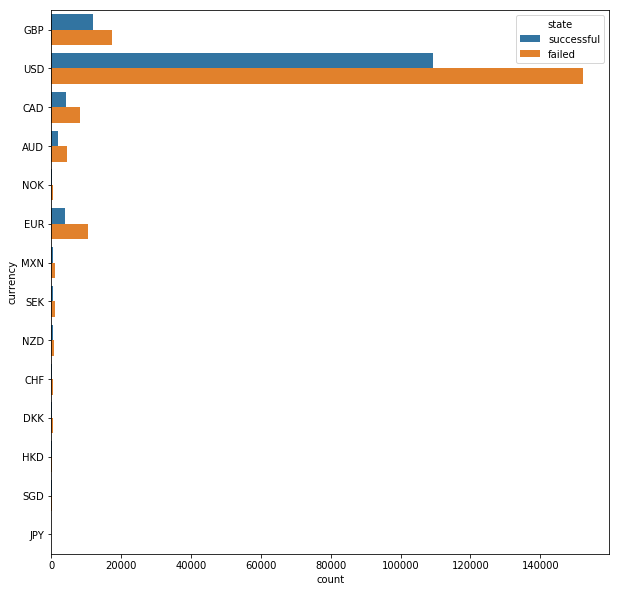

In [17]:
def showcurrencyHist(data):
    print("通貨別に見たクラウドファンディングの成否")
    sns.countplot(y="currency", hue="state", hue_order=["successful", "failed"], data=data)
    plt.show()

plt.figure(figsize=(10,10))
showcurrencyHist(df_data)

通貨ごとにあまりクラウドファンディングの成否にばらつきがみられないため、目的変数への影響は少ないと考えられる。

### 3.3 state と backers

In [18]:
df_data['backers'].describe()

count    331675.000000
mean        116.381581
std         965.427268
min           0.000000
25%           2.000000
50%          15.000000
75%          63.000000
max      219382.000000
Name: backers, dtype: float64

支持者数別に見たクラウドファンディングの成否


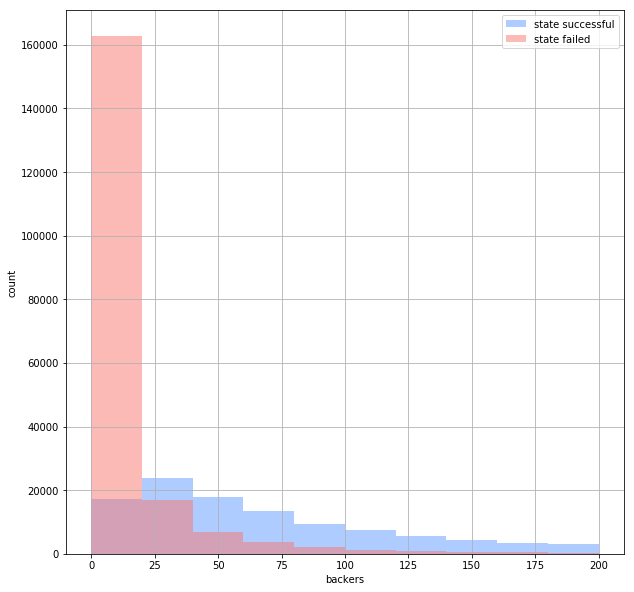

In [19]:
print("支持者数別に見たクラウドファンディングの成否")
plt.figure(figsize=(10,10))
df_data["backers"][df_data["state"]=="successful"].hist(color="#5F9BFF", alpha=.5, label=["state successful"], range=(0,200))
df_data["backers"][df_data["state"]=="failed"].hist(color="#F8766D", alpha=.5, label=["state failed"], range=(0,200))
plt.xlabel("backers")
plt.ylabel("count")
plt.legend()
plt.show()

支持者数ごとにクラウドファンディングの成否にばらつきがみられるため、支持者数は目的変数に影響を及ぼしていると推測する。

### 3.4 state と country

In [20]:
df_data['country'].value_counts()

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

アメリカ のクラウドファンディングの成否


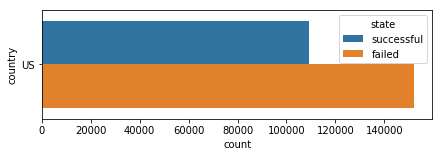

アメリカ以外の国別 のクラウドファンディングの成否


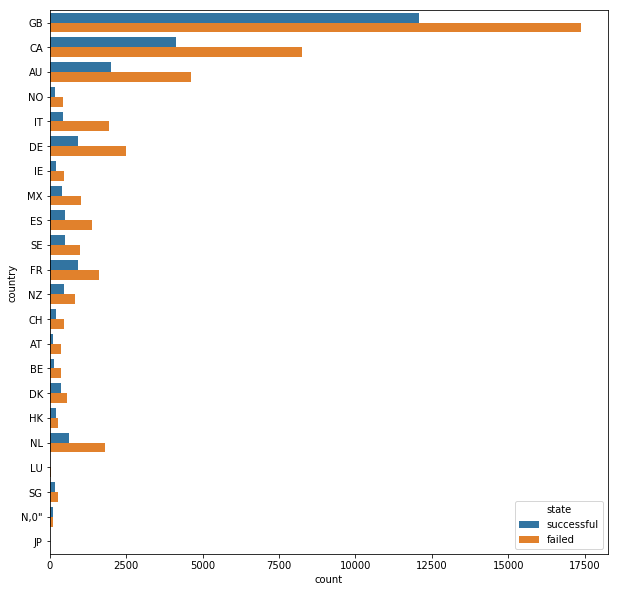

In [21]:
df_data_us = df_data[["state", "country"]][(df_data["country"]=='US')]
df_data_other = df_data[["state", "country"]][(df_data["country"] != 'US')]

def showcountryHist(data, label):
    print(label, "のクラウドファンディングの成否")
    sns.countplot(y="country", hue="state", hue_order=["successful", "failed"], data=data)
    plt.show()

plt.figure(figsize=(7,2))
showcountryHist(df_data_us, "アメリカ")
plt.figure(figsize=(10,10))
showcountryHist(df_data_other, "アメリカ以外の国別")

国ごとにあまりクラウドファンディングの成否にばらつきがみられないため、目的変数への影響は少ないと考えられる。

### 3.5 state と usd_goal_real

In [22]:
df_data['usd_goal_real'].describe()

count    3.316750e+05
mean     4.151000e+04
std      1.108930e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

目標金額別に見たクラウドファンディングの成否


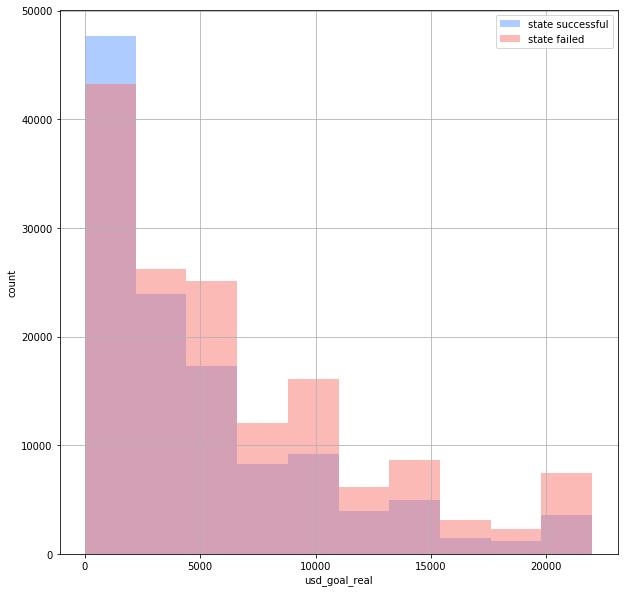

In [23]:
print("目標金額別に見たクラウドファンディングの成否")
plt.figure(figsize=(10,10))
df_data["usd_goal_real"][df_data["state"]=="successful"].hist(color="#5F9BFF", alpha=.5, label=["state successful"], range=(0,22000))
df_data["usd_goal_real"][df_data["state"]=="failed"].hist(color="#F8766D", alpha=.5, label=["state failed"], range=(0,22000))
plt.xlabel("usd_goal_real")
plt.ylabel("count")
plt.legend()
plt.show()

目的金額別に見たクラウドファンディングの成否


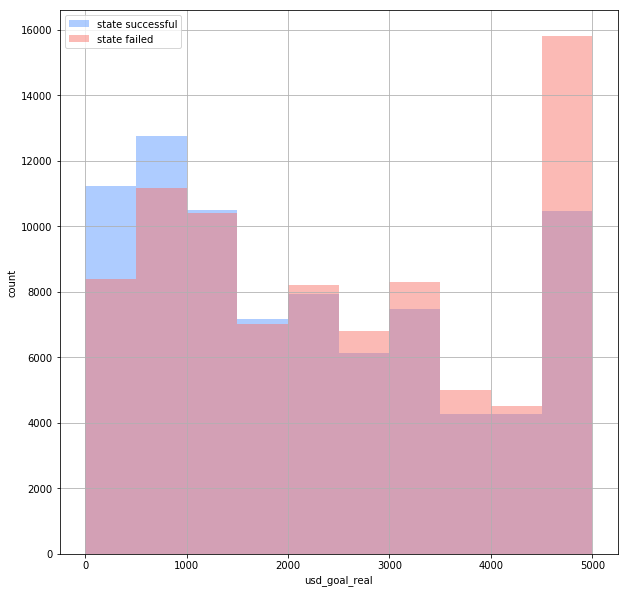

In [24]:
print("目的金額別に見たクラウドファンディングの成否")
plt.figure(figsize=(10,10))
df_data["usd_goal_real"][df_data["state"]=="successful"].hist(color="#5F9BFF", alpha=.5, label=["state successful"], range=(0,5000))
df_data["usd_goal_real"][df_data["state"]=="failed"].hist(color="#F8766D", alpha=.5, label=["state failed"], range=(0,5000))
plt.xlabel("usd_goal_real")
plt.ylabel("count")
plt.legend()
plt.show()

目的金額ごとにクラウドファンディングの成否にばらつきがみられるため、目的金額は目的変数に影響を及ぼしていると推測する。

### 3.6 state と days

In [25]:
df_data['days'].describe()

count    331675.000000
mean         32.954902
std          12.713329
min           0.000000
25%          29.000000
50%          29.000000
75%          35.000000
max          91.000000
Name: days, dtype: float64

日数別に見たクラウドファンディングの成否


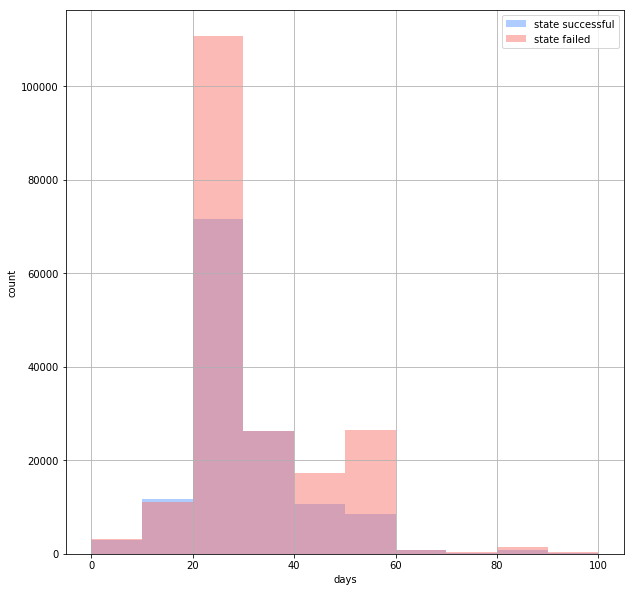

In [26]:
print("日数別に見たクラウドファンディングの成否")
plt.figure(figsize=(10,10))
df_data["days"][df_data["state"]=="successful"].hist(color="#5F9BFF", alpha=.5, label=["state successful"], range=(0,100))
df_data["days"][df_data["state"]=="failed"].hist(color="#F8766D", alpha=.5, label=["state failed"], range=(0,100))
plt.xlabel("days")
plt.ylabel("count")
plt.legend()
plt.show()

日数ごとにクラウドファンディングの成否にばらつきがあるため、日数は目的変数に影響を及ぼしていると推測する。

### 3.7 関係性のまとめ

上記比較より以下の項目がクラウドファンディングの成否に関係があると推測する。

・main_categry

・backers

・usd_goal_real

・days

In [27]:
#currencyとcountryの削除
df_data = df_data.drop(["currency","country"], axis=1)

### 4. データの前処理

### 4.1 変数の変換

In [28]:
#質的変数をダミー変数に変換する
# main_categoryの中身を確認
df_data['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Crafts', 'Games',
       'Design', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

In [29]:
df_dummy = pd.get_dummies(df_data['main_category'])
df_data = pd.concat([df_data.drop(['main_category'], axis=1), df_dummy], axis=1)
df_data.head()

,state,backers,usd_goal_real,days,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,failed,0,1533.95,58,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,failed,15,30000.00,59,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,failed,3,45000.00,44,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,failed,1,5000.00,29,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,successful,224,50000.00,34,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [30]:
#目的変数のデータを、failed:0, successful:1 に変換する
df_data['state'] = df_data['state'].map({"failed":0, "successful":1})

In [31]:
# データを分割

from sklearn.model_selection import train_test_split

y = df_data["state"].values
X = df_data.iloc[:,1:].values
X_columns = df_data.iloc[:,1:].columns

# X_train = X
# y_train = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1234)

### 4.2 各分析の評価方法の定義

分析を進めるにあたって、評価方法を定義しておく

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score,classification_report
from sklearn.ensemble import RandomForestClassifier

In [33]:
# 混同行列を表示する
def showConfusionMatrix(p_y_test, p_y_pred):
    df = pd.DataFrame({"実際":p_y_test,"予測":p_y_pred})
    df = df.groupby(["実際","予測"])[["予測"]].count()
    df.rename(columns={"予測":"num"},inplace=True)
    df.reset_index(inplace=True)
    df = df.pivot(index="実際",columns="予測",values="num")
    df.sort_index(ascending=False, inplace=True)
    df = df[[1,0]]
    
    display(df)
    plt.figure(figsize=(7,4))
    sns.heatmap(df, annot=True, cmap='coolwarm' ,fmt='4d')
    plt.show()
    
    accuracy = accuracy_score(p_y_test, p_y_pred)
    recall = recall_score(p_y_test, p_y_pred)
    precision = precision_score(p_y_test, p_y_pred)
    f1 =f1_score(p_y_test, p_y_pred)
    
    print('正答率:{:.2f}%'.format(accuracy*100))
    print('再現率:{:.2f}%'.format(recall*100))
    print('適合率:{:.2f}%'.format(precision*100))
    print('F1:{:.2f}%'.format(f1*100))
    return {"accuracy": accuracy*100, "recall": recall*100, "precision": precision*100, "f1": f1*100}

# 各アルゴリズムの分析結果を統一フォーマットで管理する
def setSummary(score, result_c):
    return{'accuracy': result_c['accuracy'],
           'recall': result_c['recall'],
           'precision': result_c['precision'],
           'f1': result_c['f1'],
          'score': score,
          }

# 各モデルの分析結果を格納する変数
summary ={}

### 5.分析

様々なアルゴリズムを用いて分析を行う。

### 5.1 ロジスティック回帰

In [34]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

y = df_data["state"].values
X = df_data.drop("state", axis=1).values

# 標準化
std_scaler = StandardScaler() 

X_scaled = std_scaler.fit_transform(X)

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, )
clf.fit(X_scaled, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
w6 = clf.coef_[0, 5]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))

w0 = -0.789, w1 = 37.270, w2 = -109.431, w3 = -0.205, w4 = 0.131, w5 = -0.031, w6 = -0.048


In [35]:
# ラベルを予測
y_est = clf.predict(X_scaled)

# 確率値を得る
y_est_proba = clf.predict_proba(X_scaled)

# 対数尤度を表示
# log_lossという関数は、負の対数尤度を返す
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est_proba, normalize=False))) 

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

対数尤度 = -111351.378
正答率 = 87.999%


,予測 = failed,予測 = successful
正解 = failed,188115,9604
正解 = successful,30199,103757


 交差検証法を行い精度が良くなるか調べてみる。

訓練のデータに対する識別率：59.75%


予測,1,0
実際,,
1,25590,1203
0,5476,34066


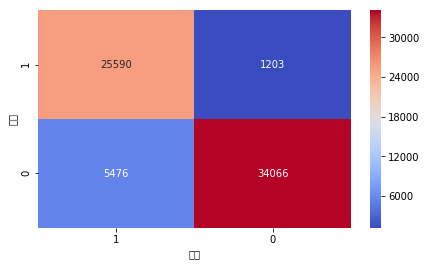

正答率:89.93%
再現率:95.51%
適合率:82.37%
F1:88.46%


In [36]:
model = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, )
for train_idx, test_idx in KFold(n_splits=5, shuffle=True, random_state=1234).split(X_scaled, y):
    
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

score = clf.score(X_train, y_train) * 100
print('訓練のデータに対する識別率：{0:.2f}%'.format(score))

result_c = showConfusionMatrix(y_test, y_pred)

summary['Logistic regression'] = setSummary(score, result_c)

交差検証法を行った結果、正答率が良くなった。

### 5.2 決定木

{'criterion': 'gini', 'min_samples_split': 5} 0.9055913168010854
訓練のデータに対する識別率：97.34%


予測,1,0
実際,,
1,23252,3541
0,2753,36789


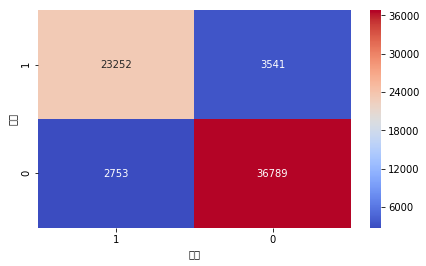

正答率:90.51%
再現率:86.78%
適合率:89.41%
F1:88.08%
各説明変数の重要度を確認


,
backers,0.719226
usd_goal_real,0.193831
days,0.043607
Games,0.010071
Film & Video,0.005430


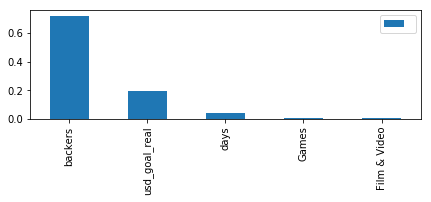

Wall time: 43 s


In [37]:
%%time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO


#グリッドサーチによる最適なパラメータの検討
params = {
        "criterion": ["gini","entropy"],
        "min_samples_split": [2, 3, 5],
        }

clf_dtc = GridSearchCV(estimator=DecisionTreeClassifier(random_state=1234),
                param_grid = params,   
                scoring="accuracy", 
                cv = 5,
                n_jobs = -1)
clf_dtc.fit(X, y)
print(clf_dtc.best_params_, clf_dtc.best_score_)


# 最適パラメータを用いて識別する
clf_dtc_tmp = DecisionTreeClassifier(**clf_dtc.best_params_)
clf_dtc_tmp.fit(X_train, y_train)

score = clf_dtc_tmp.score(X_train, y_train) * 100
print('訓練のデータに対する識別率：{0:.2f}%'.format(score))


#交差検証と評価
model = DecisionTreeClassifier(**clf_dtc.best_params_)

for train_idx, test_idx in KFold(n_splits=5, shuffle=True, random_state=1234).split(X, y):
    
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
result_c = showConfusionMatrix(y_test, y_pred)
summary['DecisionTree'] = setSummary(score, result_c)


#各説明変数の重要度を確認
print("各説明変数の重要度を確認")
df_result_score = pd.DataFrame(model.feature_importances_, index=X_columns, columns=[""])
df_sort = df_result_score.sort_values(by=[""], ascending=False).head()
display(df_sort)
df_sort.plot.bar(figsize=(7,2))
plt.show()

### 5.3 ランダムフォレスト

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False) {'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 300}
訓練のデータに対する識別率：97.36%


予測,1,0
実際,,
1,24509,2284
0,2481,37061


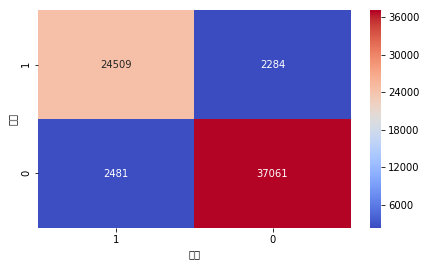

正答率:92.82%
再現率:91.48%
適合率:90.81%
F1:91.14%


,
backers,0.725791
usd_goal_real,0.192749
days,0.045247
Music,0.004945
Games,0.004496


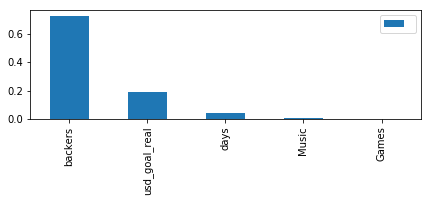

Wall time: 1h 18min 26s


In [38]:
%%time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier


#グリッドサーチによる最適なパラメータの検討
params = {
    "n_estimators":[100, 200, 300],
    "criterion": ["gini", "entropy"],
    "min_samples_split": [2, 3, 5],
}

clf_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=1234),
                param_grid = params,   
                scoring="accuracy", 
                cv=5,
                n_jobs = -1)
clf_rfc.fit(X, y)
print(clf_rfc.best_estimator_, clf_rfc.best_params_)


# 最適パラメータを用いて識別する
clf_rfc_tmp = RandomForestClassifier(**clf_rfc.best_params_)
clf_rfc_tmp.fit(X_train, y_train)

score = clf_rfc_tmp.score(X_train, y_train) * 100
print('訓練のデータに対する識別率：{0:.2f}%'.format(score))


#交差検証と評価
model = RandomForestClassifier(**clf_rfc.best_params_)
for train_idx, test_idx in KFold(n_splits=5, shuffle=True, random_state=1234).split(X, y):
    
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
result_c = showConfusionMatrix(y_test, y_pred)
summary['RandomForest'] = setSummary(score, result_c)
    
    
#各説明変数の重要度を確認
df_result_score = pd.DataFrame(model.feature_importances_, index=X_columns, columns=[""])
df_sort = df_result_score.sort_values(by=[""], ascending=False).head()
display(df_sort)
df_sort.plot.bar(figsize=(7,2))
plt.show()

### 5.4 アダブースト

In [39]:
%%time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


#グリッドサーチによる最適なパラメータの検討
param_grid = {
    "base_estimator__criterion" : ["gini", "entropy"],
    "n_estimators":[50, 100, 200],
}

DTC = DecisionTreeClassifier(random_state = 1234)
ABC = AdaBoostClassifier(base_estimator = DTC)
clf_abc    =  GridSearchCV(ABC, param_grid=param_grid, scoring = 'roc_auc', cv=5)
clf_abc.fit(X, y)

print(clf_abc.best_estimator_, clf_abc.best_params_)


# 最適パラメータを用いて識別する
clf_abc.fit(X_train, y_train)

score = clf_abc.score(X_train, y_train) * 100
print('訓練のデータに対する識別率：{0:.2f}%'.format(score))

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None) {'base_estimator__criterion': 'gini', 'n_estimators': 50}
訓練のデータに対する識別率：99.97%
Wall time: 1h 24min 43s


予測,1,0
実際,,
1,23894,2899
0,3067,36475


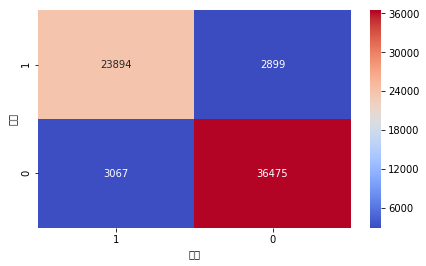

正答率:91.01%
再現率:89.18%
適合率:88.62%
F1:88.90%


,
Food,0.000525
Music,0.000347
Film & Video,0.000296
Design,0.000179
Theater,0.000172


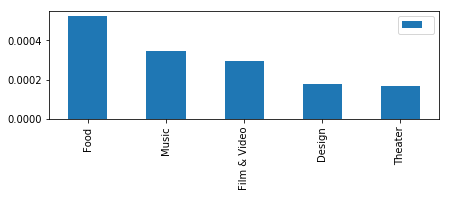

In [43]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# 交差検証と評価
# グリッドサーチの結果より
param_n_estimators = 50
param_criterion = "gini"
param_min_samples_split = 2
param_min_samples_leaf = 1


model = AdaBoostClassifier(
            DecisionTreeClassifier(
                min_samples_leaf=param_min_samples_leaf,
                min_samples_split=param_min_samples_split, 
                random_state=1234,
                criterion=param_criterion),
           n_estimators=param_n_estimators,
           random_state=None,
)

for train_idx, test_idx in KFold(n_splits=5, shuffle=True, random_state=1234).split(X, y):
    
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
result_c = showConfusionMatrix(y_test, y_pred)
summary['AdaBoost'] = setSummary(score, result_c)

#各説明変数の重要度を確認
df_result_score = pd.DataFrame(model.feature_importances_, index=X_columns, columns=[""])
df_sort = df_result_score.sort_values(by=[""], ascending=False).head()
display(df_sort)
df_sort.plot.bar(figsize=(7,2))
plt.show()

### 5.5 TensorFlow + keras

In [44]:
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import display
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras  
import tensorflow as tf
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

# 標準化
stdsc = StandardScaler()
X_train_stand = stdsc.fit_transform(X_train)
X_test_stand = stdsc.transform(X_test)

# one-hotベクトルに変換
from tensorflow.keras.utils import to_categorical
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# パラメータの設定
model = Sequential()
model.add(Dense(120, activation='relu', input_dim=X_train_stand.shape[1]))
model.add(Dense(100, activation='relu', input_dim=120))
model.add(Dense(80, activation='relu', input_dim=100))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Train on 265340 samples, validate on 66335 samples
Epoch 1/50
265340/265340 [==============================] - 18s 67us/sample - loss: 0.4322 - acc: 0.8044 - val_loss: 0.3933 - val_acc: 0.8393
Epoch 2/50
265340/265340 [==============================] - 18s 68us/sample - loss: 0.3559 - acc: 0.8485 - val_loss: 0.3480 - val_acc: 0.8567
Epoch 3/50
265340/265340 [==============================] - 18s 68us/sample - loss: 0.3335 - acc: 0.8587 - val_loss: 0.3208 - val_acc: 0.8660
Epoch 4/50
265340/265340 [==============================] - 18s 68us/sample - loss: 0.3221 - acc: 0.8641 - val_loss: 0.3494 - val_acc: 0.8536
Epoch 5/50
265340/265340 [==============================] - 18s 68us/sample - loss: 0.3112 - acc: 0.8695 - val_loss: 0.3156 - val_acc: 0.8644
Epoch 6/50
265340/265340 [==============================] - 18s 68us/sample - loss: 0.3026 - acc: 0.8730 - val_loss: 0.2879 - val_acc: 0.8789
Epoch 7/50
265340/265340 [==============================] - 18s 68us/sample - loss: 0.2957 - acc:

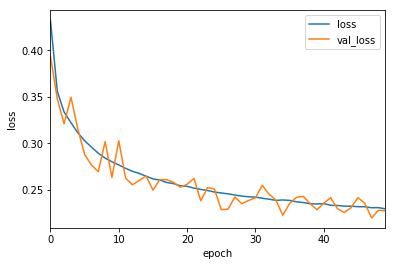

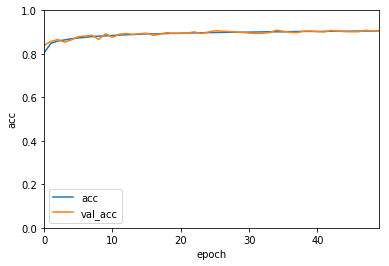

予測,1,0
実際,,
1,23665,3128
0,3020,36522


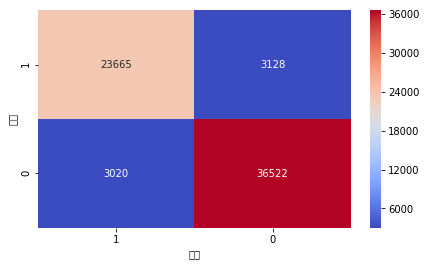

正答率:90.73%
再現率:88.33%
適合率:88.68%
F1:88.50%


In [45]:
# 計算の実行
fit = model.fit(X_train_stand, y_train_onehot,
          epochs=50,
          batch_size=20,validation_data=(X_test_stand, y_test_onehot))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()


#評価
y_pred = np.argmax(model.predict(X_test_stand),axis=1)

score = 0
result_c = showConfusionMatrix(y_test, y_pred)
summary['TensorFlow'] = setSummary(score, result_c)

In [46]:
from tensorflow.compat.v1.keras.models import load_model

# 保存
model.save('Tensorflow_model.h5')
del model

### 6. まとめ

In [47]:
summary_columns = ["accuracy", "recall", "precision", "f1", "score"]
summary_t = pd.DataFrame(summary).T

df_sort = summary_t[summary_columns].sort_values(by=["accuracy"], ascending=False);
display(df_sort)

,accuracy,recall,precision,f1,score
RandomForest,92.816763,91.475385,90.807707,91.140323,97.357353
AdaBoost,91.006256,89.180010,88.624309,88.901291,0.000000
TensorFlow,90.731891,88.325309,88.682781,88.503684,0.000000
DecisionTree,90.511796,86.783861,89.413574,88.079094,97.344916
Logistic regression,89.931409,95.510021,82.373012,88.456420,59.747117


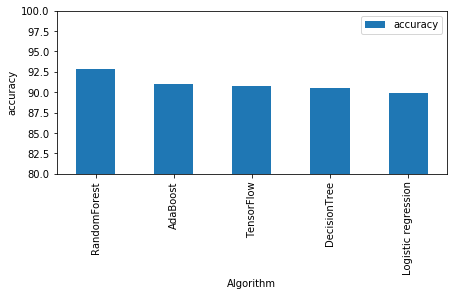

In [50]:
df_sort = df_sort[["accuracy"]]
df_sort.plot.bar(figsize=(7,3))
plt.ylabel("accuracy")
plt.xlabel("Algorithm")
plt.ylim([80, 100.0])
plt.show()